# Question Q14

*Question*: Do you/your organization follow the practice and principles of ML-Ops in ML-enabled system projects? For instance, do you have an automated pipeline to retrain and deploy your ML models?

*Answer Type*: Single Option and Free Field

*Options*: [Yes. Please optionally provide details about your ML-Ops approach:; No]

### Necessary Libraries

In [1]:
import pandas as pd
from utils.basic import rename_values, format_wordcloud_text
from utils.dataframe import DataframeUtils
from utils.plot import PlotUtils
from utils.bootstrapping import BootstrappingUtils

### Dataframe Init

In [2]:
dataframe_obj = DataframeUtils('./data/main_data.csv', ';', './data/unused_columns.txt', './data/formatted_columns.txt')
# the index is not important, but when we internally format df we need to reset index
dataframe_obj.df = dataframe_obj.df.reset_index(drop=True)

In [3]:
# For PROFES, we discarded suspended submissions (e.g., remove those who didn't complete the survey).
dataframe_obj.df.drop(dataframe_obj.df[dataframe_obj.df['Status'] == 'Suspended (22)'].index, inplace = True)

In [4]:
# question options
principles = {
    'Q14_Model_Deploy_Pipeline_Yes': 'Yes',
    'Q14_Model_Deploy_Pipeline_No': 'No'
}

### Basic Analysis

In [5]:
dataframe_obj.df[['Q14_Model_Deploy_Pipeline_Yes', 'Q14_Model_Deploy_Pipeline_No',
                  'Q14_Model_Deploy_Pipeline_Yes_Free', ]].head()

,Q14_Model_Deploy_Pipeline_Yes,Q14_Model_Deploy_Pipeline_No,Q14_Model_Deploy_Pipeline_Yes_Free
0,not quoted,not quoted,-99
1,not quoted,quoted,-99
2,not quoted,quoted,-99
3,not quoted,quoted,-99
4,quoted,not quoted,-99


In [6]:
indexes = []
values = []
for principle in principles:
    indexes.append(principles[principle])
    values.append(dataframe_obj.df[principle].value_counts()['quoted'])

In [7]:
# compute total of unique answers in this question
total = 0
for idx, row in dataframe_obj.df.iterrows():
    
    if row['Q14_Model_Deploy_Pipeline_Yes'] == 'quoted' or row['Q14_Model_Deploy_Pipeline_No'] == 'quoted':
        total += 1

total_answers = 'N = ' + str(total)
total_answers_int = total

In [8]:
# plot object
q14_plot = PlotUtils(pd.DataFrame(
    data={'Follow Principles?': indexes, 'Answers': values}
).sort_values(by=['Answers'], ascending=False))

C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


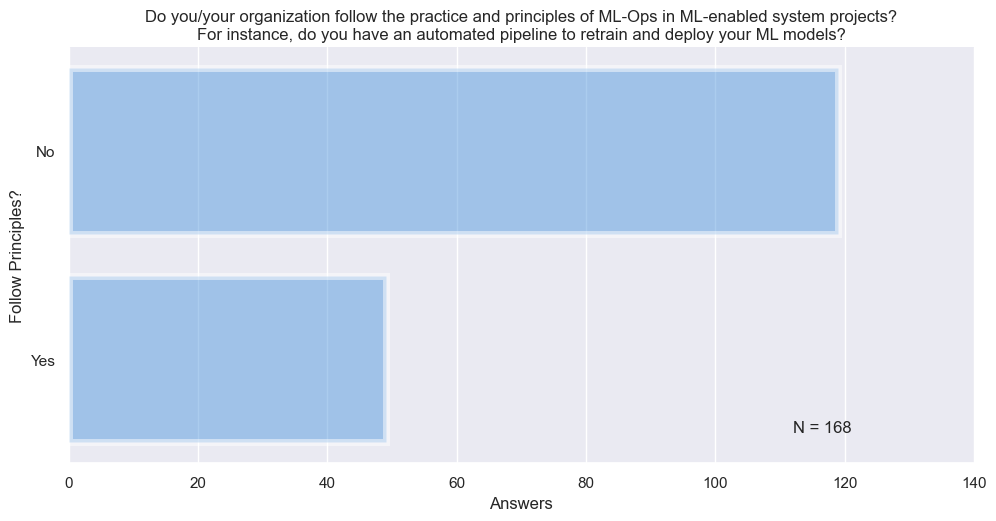

In [9]:
q14_plot.single_barplot(x_axis="Answers", y_axis="Follow Principles?",
                       title="Do you/your organization follow the practice and principles of ML-Ops in ML-enabled system projects?\nFor instance, do you have an automated pipeline to retrain and deploy your ML models?",
                       x_label="Answers", y_label="Follow Principles?", x_label_rotation=0, color="#429bf5", total_answers=total_answers)

#### WordCloud

In [10]:
principles_free = list(filter(lambda a: str(a) != '-99', 
                           list(dataframe_obj.df['Q14_Model_Deploy_Pipeline_Yes_Free'])))
principles_free = list(filter(lambda a: str(a) != '-66', principles_free))
principles_free = list(filter(lambda a: str(a) != 'nan', principles_free))

In [11]:
principles_words = format_wordcloud_text(texts=principles_free, use_sep=False)

In [12]:
# plot object
q14_wc_plot = PlotUtils(pd.DataFrame(
    data={'Word': list(principles_words.keys()), 'Weight': list(principles_words.values())}
))

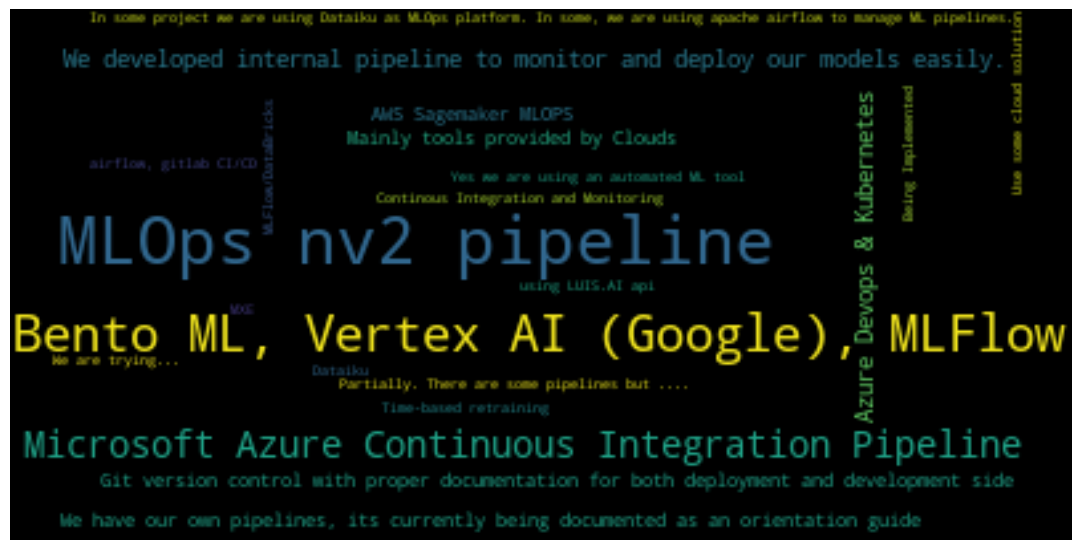

In [13]:
q14_wc_plot.wordcloud("Word", 'Weight')

### Bootstrapping Analysis

In [14]:
prefix = "Q14_Model_Deploy_Pipeline_"

In [15]:
# the possible answers are the ones in columns
valid_options_list = [principle_column.split(prefix)[1] for principle_column in principles]

In [16]:
# answers could be composed by more than one option, so we will have an array of selected options
valid_answers_list = []
for idx, row in dataframe_obj.df.iterrows():
    answer = []
    for option in valid_options_list:
        if row[prefix + option] == 'quoted':
            answer.append(option)
            
    valid_answers_list.append(answer)

In [17]:
replacements = 1000
population_sample_size = total_answers_int # equals n - total valid answers

bootstrapping_obj = BootstrappingUtils(valid_answers_list, valid_options_list, replacements, population_sample_size, 95)

In [18]:
bootstrapped_dict_data = bootstrapping_obj.bootstrapping(question_type="multiple")

In [19]:
# get a pair of values between dict key and all the list values inside that key 
# key: [val_1, val_2] ---> [(key, val_1), (key, val_2)...]
indexes = []
values = []
for idx in bootstrapped_dict_data:
    indexes += [idx for _ in range(len(bootstrapped_dict_data[idx]['population']))]
    values += bootstrapped_dict_data[idx]['population']

In [20]:
values = [100 * v for v in values]

In [21]:
# plot object for bootstrapped data
q14_boot_plot = PlotUtils(pd.DataFrame(
    data={'Follow Principles?': indexes, 'Value': values}
).sort_values(by=['Value'], ascending=False))

C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


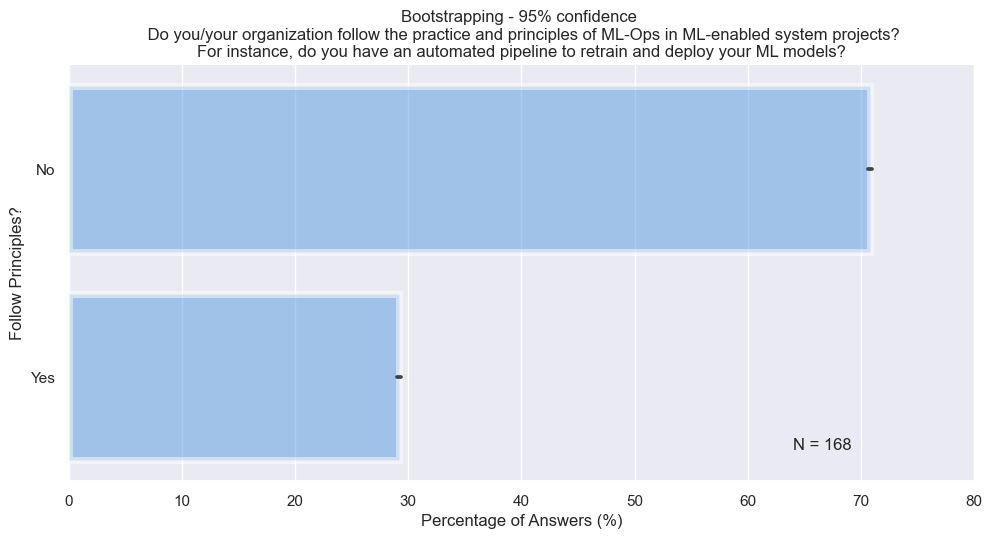

In [22]:
q14_boot_plot.single_barplot(x_axis="Value", y_axis="Follow Principles?", 
                       title="Bootstrapping - 95% confidence \n Do you/your organization follow the practice and principles of ML-Ops in ML-enabled system projects?\nFor instance, do you have an automated pipeline to retrain and deploy your ML models?",
                       x_label="Percentage of Answers (%)", y_label="Follow Principles?", x_label_rotation=0, color="#429bf5",
                       total_answers=total_answers)

In [23]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':' + str(bootstrapped_dict_data[idx]['confidence']))

Option: (Lower Value, Mean, Upper Value)
Yes:(0.28983601400007536, 0.29176785714285713, 0.2936997002856389)
No:(0.706300299714361, 0.7082321428571429, 0.7101639859999247)


In [24]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':: P = ' + str(round((bootstrapped_dict_data[idx]['confidence'][1] * 100), 3)) + " [" + str(round((bootstrapped_dict_data[idx]['confidence'][0] * 100), 3)) + ", " + str(round((bootstrapped_dict_data[idx]['confidence'][2] * 100), 3)) + "]")

Option: (Lower Value, Mean, Upper Value)
Yes:: P = 29.177 [28.984, 29.37]
No:: P = 70.823 [70.63, 71.016]
